- python 2.7  
- cv2 3.4

In [1]:
import numpy as np
import cv2
from cv2 import aruco
import pickle
import glob
import math
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
# import pandas as pd
# %matplotlib nbagg
%matplotlib inline

In [2]:
def save_img(name, img):
    file_name = os.path.join("output/test", name)
    cv2.imwrite(file_name, img)

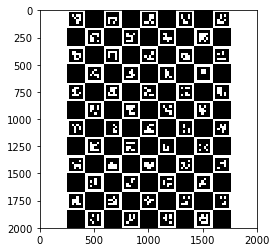

In [3]:
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_4X4_250)
CHARUCO_BOARD = aruco.CharucoBoard_create(
        squaresX=9,
        squaresY=12,
        squareLength=0.02,
        markerLength=0.015,
        dictionary=ARUCO_DICT)
type(CHARUCO_BOARD)
imboard = CHARUCO_BOARD.draw((2000, 2000))

save_img("CHARUCO_BOARD.png", imboard)

# # cv2.imwrite(workdir + "chessboard.tiff", imboard)
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
# ax.axis("off")
plt.show()

In [4]:
# # Create the arrays and variables we'll use to store info like corners and IDs from images processed
# corners_all = [] # Corners discovered in all images processed
# ids_all = [] # Aruco ids corresponding to corners discovered
# image_size = None # Determined at runtime
# imgs=[]

# # This requires a set of images or a video taken with the camera you want to calibrate
# # All images used should be the same size, which if taken with the same camera shouldn't be a problem
# images = glob.glob('picture/0720/*.jpg')
# print(len(images))

In [5]:
def get_images_corners_and_ids(images_dir_list):
    corners_all = [] # Corners discovered in all images processed
    ids_all = [] # Aruco ids corresponding to corners discovered
    image_size = None
    
    for iname in images_dir_list:
        img = cv2.imread(iname)
        # Grayscale the image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find aruco markers in the query image
        corners, ids, _ = aruco.detectMarkers(
                image=gray,
                dictionary=ARUCO_DICT)
        
        if len(corners) > 10:
        # Outline the aruco markers found in our query image
            img = aruco.drawDetectedMarkers(
                    image=img, 
                    corners=corners)  

            # Get charuco corners and ids from detected aruco markers
            response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
                    markerCorners=corners,
                    markerIds=ids,
                    image=gray,
                    board=CHARUCO_BOARD)
            
            # Add these corners and ids to our calibration arrays
            corners_all.append(charuco_corners)
            ids_all.append(charuco_ids)
        # If our image size is unknown, set it now
    if not image_size:
        image_size = gray.shape[::-1]   
               
    return corners_all, ids_all, image_size

def get_cam_matrix(images_path='picture/0720/*.jpg', save_calibration_dir="./"):
    # -----------------------------------------------
    # input images directory
    images_dir_list = glob.glob(images_path)
    # -----------------------------------------------
    # get images corners and ids 
    corners_all, ids_all, image_size = get_images_corners_and_ids(images_dir_list)
    # -----------------------------------------------
    # get cameraMatrix and distCoeffs
    calibration, cameraMatrix, distCoeffs, rvecs, tvecs = aruco.calibrateCameraCharuco(
        charucoCorners=corners_all,
        charucoIds=ids_all,
        board=CHARUCO_BOARD,
        imageSize=image_size,
        cameraMatrix=None,
        distCoeffs=None)
    # -----------------------------------------------
    # save cameraMatrix and distCoeffs
    f = open('{}/calibration.pckl'.format(save_calibration_dir), 'wb')
    pickle.dump((cameraMatrix, distCoeffs), f)
    f.close()
    
    
    return cameraMatrix, distCoeffs, calibration
    


# cameraMatrix, distCoeffs, calibration = get_cam_matrix(images_path='picture/0720/*.jpg')

In [6]:
def AngleAxis2EulerZYX(rvec):
    
    R=cv2.Rodrigues(rvec)
    return Mat2Euler(R[0])

def Mat2Euler(_R):
#     sy = math.sqrt(_R.at<double>(0,0) * _R.at<double>(0,0) +  _R.at<double>(1,0) * _R.at<double>(1,0) );
#     sy = math.sqrt(_R[0,0] * _R[0,0] +  _R[0,1] * _R[0,1] );
    sy = math.sqrt(_R[0,0] * _R[0,0] +  _R[1,0] * _R[1,0] );
    if (sy < 1e-6): # If
        singular=True
    else:
        singular=False
#     float x, y, z;
    if (not singular):
#         x = atan2(_R.at<double>(2,1) , _R.at<double>(2,2));
#         y = atan2(-_R.at<double>(2,0), sy);
#         z = atan2(_R.at<double>(1,0), _R.at<double>(0,0));
#         x = math.atan2(_R[1,2] , _R[2,2]);
#         y = math.atan2(-_R[0,2], sy);
#         z = math.atan2(_R[0,1], _R[0,0]);
        x = math.atan2(_R[2,1] , _R[2,2]);
        y = math.atan2(-_R[2,0], sy);
        z = math.atan2(_R[1,0], _R[0,0]);
    else:
#         x = atan2(-_R.at<double>(1,2), _R.at<double>(1,1));
#         y = atan2(-_R.at<double>(2,0), sy);
#         z = 0;
#         x = math.atan2(-_R[2,1], _R[1,1]);
#         y = math.atan2(-_R[0,2], sy);
#         z = 0;
        x = math.atan2(-_R[1,2], _R[1,1]);
        y = math.atan2(-_R[2,0], sy);
        z = 0;
    
    return [x, y, z]

In [7]:
def get_rvec2_and_tvec2(image, cameraMatrix, distCoeffs):
    # Grayscale the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find aruco markers in the query image
    corners, ids, _ = aruco.detectMarkers(
            image=gray,
            dictionary=ARUCO_DICT)
    
    is_detected = False
    if len(corners) > 10:
        is_detected = True
        # Get charuco corners and ids from detected aruco markers
        response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
                markerCorners=corners,
                markerIds=ids,
                image=gray,
                board=CHARUCO_BOARD)

        ret2, rvec2, tvec2 = aruco.estimatePoseCharucoBoard(charuco_corners, charuco_ids, CHARUCO_BOARD, cameraMatrix, distCoeffs)
    else:
        rvec2 = tvec2 = None
    return rvec2, tvec2, is_detected

def shift_coordinate(rvec2, tvec2):
    Euler = AngleAxis2EulerZYX(rvec2)
    tx = (CHARUCO_BOARD.getChessboardSize()[0]) * (CHARUCO_BOARD.getSquareLength())/2
    ty = (CHARUCO_BOARD.getChessboardSize()[1]) * (CHARUCO_BOARD.getSquareLength())/2
    # TransO = (Mat_<double>(3,1) <<tx,ty,0);
    TransO = np.array([tx,ty,0])

    R=cv2.Rodrigues(rvec2)
    Trans_tvec = R[0].dot(TransO)
    CharucoPose=[0,0,0,0,0,0]
    for j in range(3):
        tvec2[j]+=Trans_tvec[j]
    #     tvec[i]=tvec[i]+Trans_tvec.at<double>(i,0)
        CharucoPose[j]  = tvec2[j][0]*1000
        CharucoPose[j+3]= Euler[j]*180/math.pi
    return rvec2, tvec2

def draw_coordinate(image, cameraMatrix, distCoeffs, rvec2, tvec2):

    return aruco.drawAxis(image,cameraMatrix,distCoeffs,rvec2,tvec2,0.1)

__name__ == "__main__"

('cam error:', 10.515418362536778)
(array([[687.21521611,   0.        , 628.14354548],
       [  0.        , 689.40767124, 355.35347065],
       [  0.        ,   0.        ,   1.        ]]), array([[ 0.02410052, -0.1142199 , -0.00406845, -0.01209018,  0.16403384]]))
(array([[ 2.12449347],
       [ 2.22239832],
       [-0.15670418]]), array([[-0.1147617 ],
       [-0.12325753],
       [ 0.39782051]]))


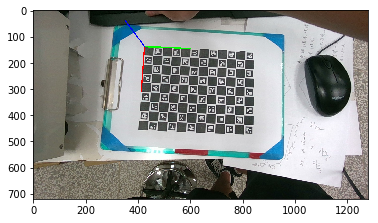

(array([[-1.45577343],
       [ 2.55363696],
       [-0.06170505]]), array([[ 0.11868098],
       [-0.02089144],
       [ 0.48791346]]))


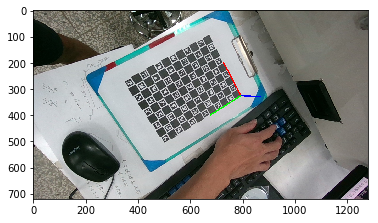

(array([[ 1.11018567],
       [-2.65871591],
       [-0.49534768]]), array([[ 0.18669079],
       [-0.07420162],
       [ 0.43433131]]))


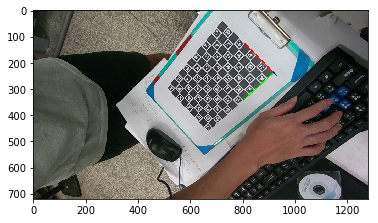

(array([[0.14858962],
       [2.09937004],
       [0.23736093]]), array([[ 0.02493206],
       [-0.11442014],
       [ 0.50689686]]))


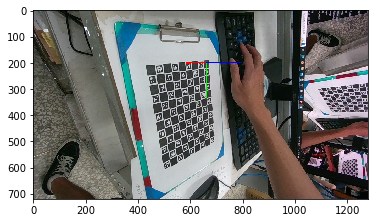

(array([[ 1.35706182],
       [ 2.15462592],
       [-0.74165544]]), array([[ 0.013505  ],
       [-0.05766719],
       [ 0.51319842]]))


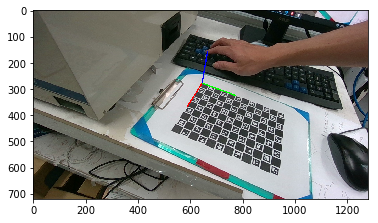

(array([[ 0.93285157],
       [ 2.54508528],
       [-1.01274857]]), array([[ 0.04902614],
       [-0.14655245],
       [ 0.4821749 ]]))


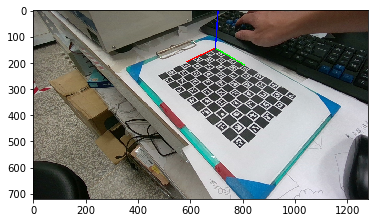

(array([[-0.84525773],
       [-2.60650978],
       [-0.89135072]]), array([[ 0.02835356],
       [-0.13433313],
       [ 0.34741364]]))


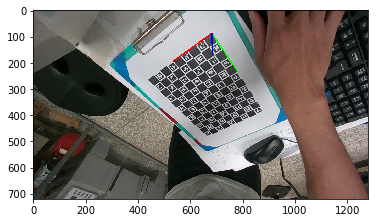

(array([[ 1.0445206 ],
       [-2.37442696],
       [-0.22694565]]), array([[ 0.14366334],
       [-0.00364563],
       [ 0.33476314]]))


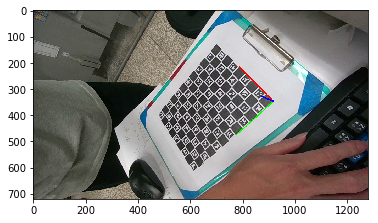

(array([[ 1.03872998],
       [-2.36270799],
       [-0.69767976]]), array([[0.23188365],
       [0.01609658],
       [0.30539342]]))


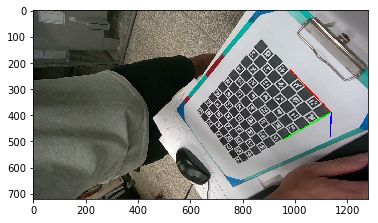

(array([[1.19258459],
       [2.45835088],
       [0.09033599]]), array([[-0.03085318],
       [-0.14372345],
       [ 0.35430785]]))


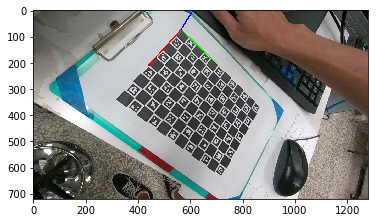

(array([[-1.0115197 ],
       [-2.34332527],
       [ 0.59613997]]), array([[ 0.02683885],
       [-0.16585381],
       [ 0.4633449 ]]))


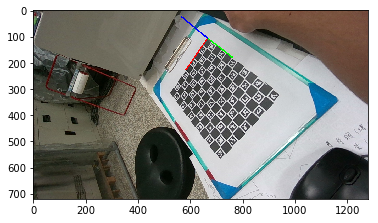

(array([[ 2.06691722],
       [ 2.1859452 ],
       [-0.27344533]]), array([[-0.08902429],
       [-0.07599107],
       [ 0.530629  ]]))


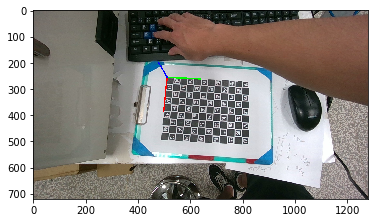

(array([[-2.06484353],
       [-1.2550394 ],
       [-0.17276289]]), array([[-0.17308147],
       [-0.08286795],
       [ 0.44950958]]))


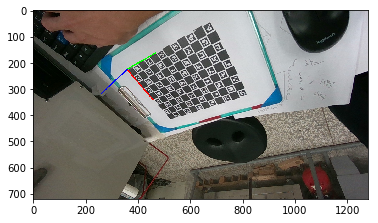

(array([[-2.46921343],
       [-0.71341637],
       [-0.44166062]]), array([[-0.17255392],
       [ 0.06017719],
       [ 0.46406051]]))


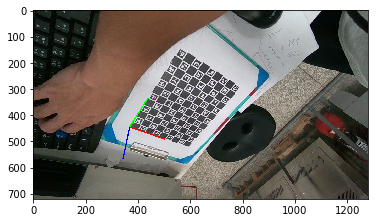

(array([[-2.69938792],
       [-0.24490811],
       [-0.81185261]]), array([[-0.21477145],
       [ 0.14300557],
       [ 0.42386282]]))


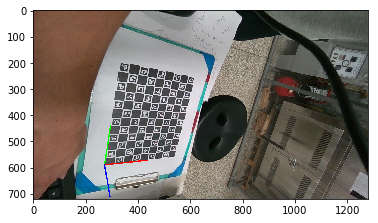

(array([[-0.04193144],
       [ 3.09630411],
       [-0.33229177]]), array([[ 0.0909471 ],
       [-0.09635184],
       [ 0.39271786]]))


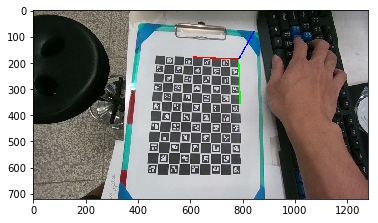

(array([[-1.96991944],
       [-2.27883688],
       [ 0.05060032]]), array([[-0.0721319 ],
       [-0.17839964],
       [ 0.4588151 ]]))


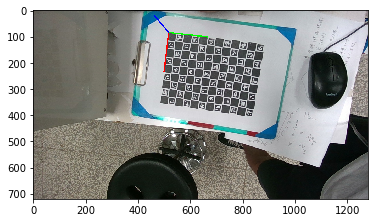

(array([[-1.91855159],
       [-2.2714517 ],
       [-0.24620876]]), array([[-0.08099587],
       [-0.08613604],
       [ 0.25446902]]))


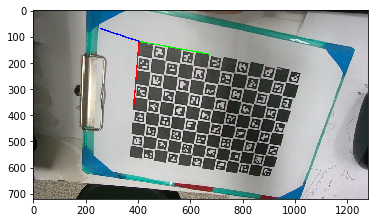

(array([[-1.95243923],
       [-2.26625318],
       [-0.03658101]]), array([[-0.09386764],
       [-0.1009262 ],
       [ 0.22109987]]))


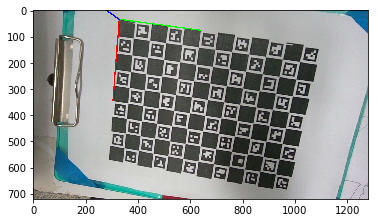

(array([[ 1.43590181],
       [ 2.14011202],
       [-0.22933272]]), array([[-0.1170374 ],
       [-0.1379922 ],
       [ 0.37667802]]))


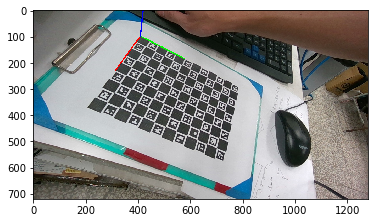

(array([[-1.29163709],
       [-2.570226  ],
       [ 1.13021064]]), array([[ 0.0140998 ],
       [-0.12123534],
       [ 0.46341204]]))


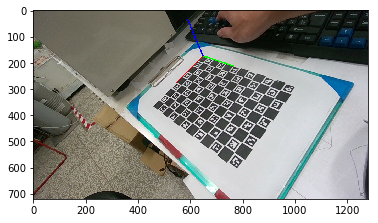

(array([[-1.97681325],
       [-1.09024375],
       [ 0.94781164]]), array([[0.09518532],
       [0.01313816],
       [0.52918116]]))


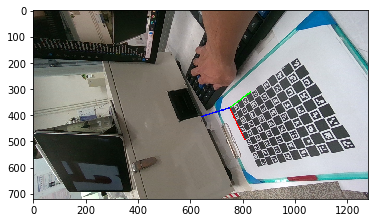

(array([[-2.16616248],
       [-2.18788776],
       [ 0.50574163]]), array([[-0.08284705],
       [-0.07277079],
       [ 0.52474447]]))


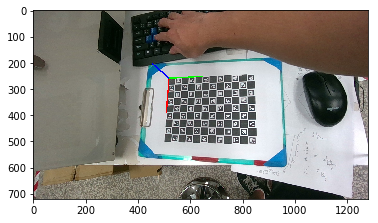

(array([[1.67756728],
       [1.92487222],
       [0.57139826]]), array([[-0.16212115],
       [-0.09524698],
       [ 0.40066056]]))


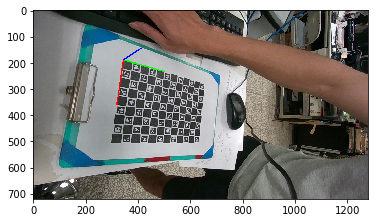

(array([[2.25136751],
       [2.17859579],
       [0.11292423]]), array([[-0.18076184],
       [-0.05533738],
       [ 0.45646922]]))


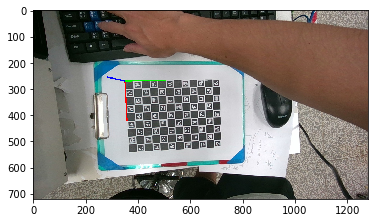

(array([[1.80600463],
       [1.94006065],
       [0.36338302]]), array([[-0.18539787],
       [-0.0855078 ],
       [ 0.43226012]]))


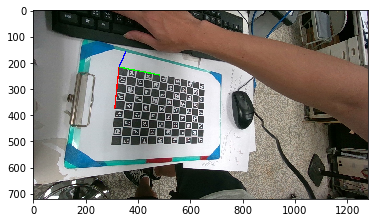

(array([[ 1.7752434 ],
       [ 2.05038609],
       [-0.62979671]]), array([[-0.10618053],
       [-0.03933091],
       [ 0.48432819]]))


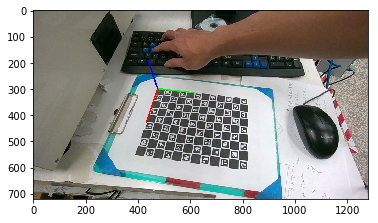

(array([[ 1.08596719],
       [ 2.50555121],
       [-0.92652636]]), array([[-0.04946817],
       [-0.15303406],
       [ 0.50213193]]))


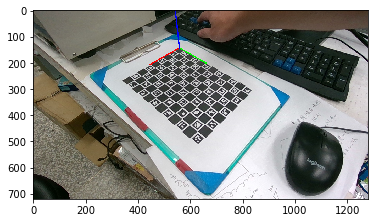

(array([[ 0.57964643],
       [ 2.78020887],
       [-1.07387127]]), array([[ 0.00562307],
       [-0.14339152],
       [ 0.5080907 ]]))


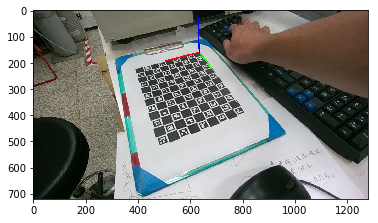

(array([[-0.14994455],
       [ 2.86641849],
       [-0.77500807]]), array([[ 0.02885289],
       [-0.10356601],
       [ 0.51198052]]))


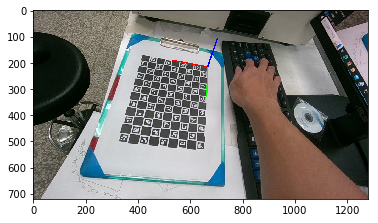

(array([[-0.05817061],
       [-2.82232727],
       [ 0.25982412]]), array([[ 0.11033187],
       [-0.13761121],
       [ 0.48518144]]))


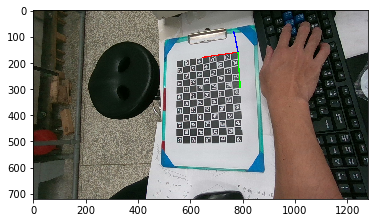

In [9]:
try:

    # 打開並讀取保存的校準數據文件
    with open('calibration.pckl', 'rb') as f:
        cameraMatrix, distCoeffs = pickle.load(f)
except:
    cameraMatrix, distCoeffs, calibration = get_cam_matrix(images_path=r'C:\Users\NEAF\code\yen\take_photo\images\Jun11_H21_M45_S47\*_color.jpg')
    # cameraMatrix, distCoeffs, calibration = get_cam_matrix(images_path='picture/0720/*.jpg')

print("cam error:", calibration)
print(cameraMatrix, distCoeffs)

images = glob.glob(r'C:\Users\NEAF\code\yen\take_photo\images\Jun11_H21_M45_S47\*_color.jpg')
# images = glob.glob(r'C:\Users\NEAF\code\yen\take_photo\images\Jun11_H22_M15_S04\*_color.jpg')
# images = glob.glob('picture/0720_test/*.jpg')

for image_dir in images:
    image = cv2.imread(image_dir)

    rvec2, tvec2, is_detected = get_rvec2_and_tvec2(image, cameraMatrix, distCoeffs)
    print(rvec2, tvec2)
    # rvec2, tvec2 = shift_coordinate(rvec2, tvec2)
    if is_detected:
        image_drawed = draw_coordinate(image, cameraMatrix, distCoeffs, rvec2, tvec2)
    else:
        image_drawed = image
    
    plt.imshow(cv2.cvtColor(image_drawed, cv2.COLOR_RGB2BGR))
    plt.show()

In [11]:
distCoeffs.shape == (1L, 5L)

True

In [20]:
import pyrealsense2 as rs
import numpy as np
import cv2
from datetime import datetime
import os

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
# config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
# config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# path
current_time = datetime.now().strftime("%b%d_H%H_M%M_S%S")
image_dir = "./images/{}".format(current_time)

if not os.path.exists(image_dir):
    # 如果資料夾不存在，則創建它
    os.makedirs(image_dir)

pipeline.start(config)
i = 0
try:
    while True:
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        if not depth_frame or not color_frame:
            continue

        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        depth_image = cv2.flip(depth_image, -1)
        color_image = cv2.flip(color_image, -1)

        # color image add coordination
        rvec2, tvec2, is_detected = get_rvec2_and_tvec2(color_image, cameraMatrix, distCoeffs)
        if is_detected:
            color_image = draw_coordinate(color_image, cameraMatrix, distCoeffs, rvec2, tvec2)

            # 定義要添加的文字
            text = "rvec2: {} \n tvec2: {}".format([round(x, 3) for x in rvec2], [round(x, 3) for x in tvec2])
            
            # 定義文字的位置（左下角）
            org = (50, 50)
            
            # 定義字體
            font = cv2.FONT_HERSHEY_SIMPLEX
            
            # 定義字體大小
            font_scale = 1
            
            # 定義字體顏色（BGR格式）
            color = (255, 0, 0)  # 藍色
            
            # 定義字體厚度
            thickness = 2
            
            # 在圖片上添加文字
            cv2.putText(color_image, text, org, font, font_scale, color, thickness, cv2.LINE_AA)
            
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        images = np.hstack((color_image, depth_colormap))

        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', color_image)
        key = cv2.waitKey(100)
        if key & 0xFF == ord('q') or key == 27:
            cv2.destroyAllWindows()
            break
        elif key & 0xFF == ord('s'):
            cv2.imwrite("{}/img_{}.jpg".format(image_dir, i), images)
            cv2.imwrite("{}/img_{}_color.jpg".format(image_dir, i), color_image)
            cv2.imwrite("{}/img_{}_depth.jpg".format(image_dir, i), depth_image)
            i += 1

finally:
    pipeline.stop()